# ANTs MRI normalisation

To perform pre-processing on the images we will need a template MRI. We shall create this using the advanced normalisation tools (ANTs) package.

In [1]:
import os
import ants
import time
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

Get the MRI paths.

In [2]:
base_dir = "/mnt/HDD/Data/nipype_test"
data_dir = os.path.join(base_dir, "samples")
out_dir = os.path.join(base_dir, "results")
template_dir = os.path.join(base_dir, "templates")

data_paths = [os.path.join(data_dir, path) for path in os.listdir(data_dir) if path[-4:] == ".nii"]

## Create template

We shall create a template MRI from a smaller sample of the MRIs.

First we shall take a sample and create ANTs objects from them.

In [4]:
sample_paths = np.random.choice(data_paths, 10).tolist()
image_list = [ants.image_read(path) for path in sample_paths]
image_list

[ANTsImage (SAR)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (256, 256, 166)
 	 Spacing    : (0.9477, 0.9375, 1.202)
 	 Origin     : (-98.3389, -161.998, 97.6562)
 	 Direction  : [-0.  0.  1.  0.  1. -0. -1.  0.  0.],
 ANTsImage (SAR)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (256, 256, 166)
 	 Spacing    : (0.9478, 0.9442, 1.2022)
 	 Origin     : (-97.0974, -154.605, 108.751)
 	 Direction  : [-0. -0.  1. -0.  1.  0. -1. -0.  0.],
 ANTsImage (SAR)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (256, 256, 166)
 	 Spacing    : (0.9476, 0.9375, 1.2021)
 	 Origin     : (-94.5613, -137.921, 121.434)
 	 Direction  : [-0.  0.  1.  0.  1. -0. -1.  0.  0.],
 ANTsImage (SAR)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (256, 256, 166)
 	 Spacing    : (1.0241, 1.024, 1.2037)
 	 Origin     : (-100.269, -145.98, 125.054)
 	 Direction  : [-0. -0.  1. -0.  1.  0. -1. -0.  0.],
 ANTsImage (SAR)
 	 Pixel Type : float 

Now we can create the template MRI.

In [5]:
template = ants.build_template(image_list=image_list)

0.60721844


In [ ]:
template

Let's look at the generated template.

In [ ]:
template_array = template.numpy()
coronal_slice = template_array[:, template_array.shape[1] // 2, :]

plt.imshow(coronal_slice, cmap="gray")

Lets save the template for use later.

In [ ]:
template_name = time.strftime("mri_template_%Y_%m_%d-%H-%M-%S")
template_path = os.path.join(template_dir, template_name)

ants.image_write(template, filename=template_path)

## Normalise MRIs

Now we can normalise each of the MRIs by warping to fit the template.

Lets load in the template we just created.

In [ ]:
template_name = ""
template_path = os.path.join(template_dir, template_name)
template = ants.image_read(template_path)

## ATLAS Human Template

We can do the same thing with the Human MRI Template from USC.

It is in MINC format so we will need to convert it to NII.

In [21]:
atlas_dir = "/mnt/HDD/Data/nipype_test/templates/human_atlas/"
atlas_mnc_path = os.path.join(atlas_dir, "sample_human_t1.mnc")

atlas_mnc = nib.load(atlas_path)
atlas_nii = nib.Nifti1Image(
    atlas_mnc.get_fdata(), 
    affine=atlas_mnc.affine, 
    header=atlas_mnc.header
)

atlas_nii_path = os.path.join(atlas_dir, "sample_human_t1.nii")
nib.save(atlas_nii, atlas_nii_path)

Let's explore the template.

In [29]:
volume = atlas_nii.get_fdata()
volume.shape

(256, 256, 170)

Now we can visualise the MRI.

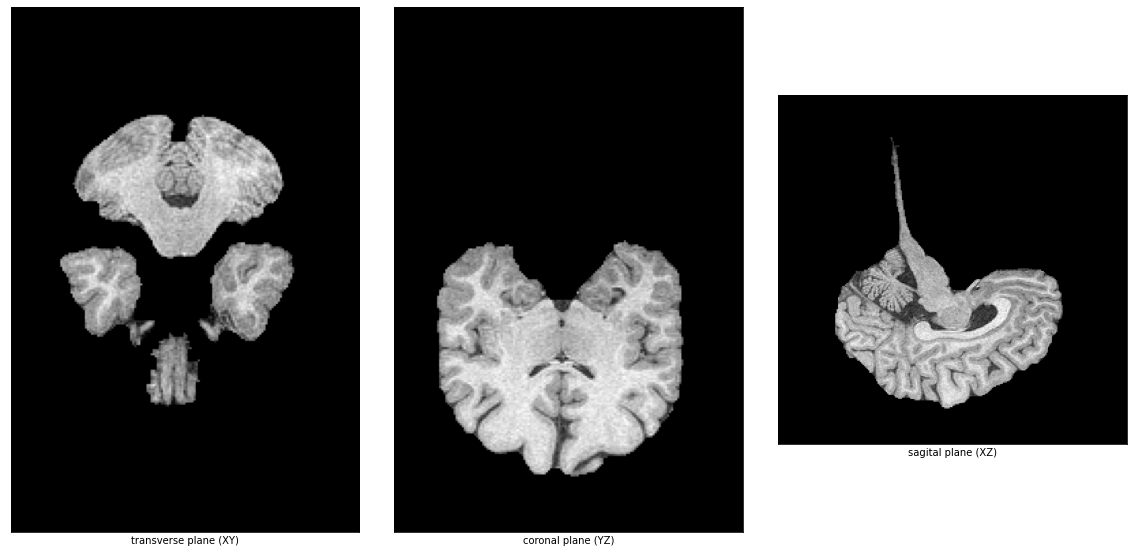

In [31]:
# in transverse plane middle of the brain is ~1/3 depth of XY plane
transverse_slice = ("transverse plane (XY)", volume[volume.shape[0] // 2, :, :]) 
coronal_slice = ("coronal plane (YZ)", volume[:, volume.shape[1] // 2, :])
sagital_slice = ("sagital plane (XZ)", volume[:, :, volume.shape[2] // 2])

fig = plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, (plane, img) in enumerate([transverse_slice, coronal_slice, sagital_slice]):
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([]) 
    ax.set_yticks([])
    ax.set_xlabel(plane)